## Importing Libraries

In [64]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import accuracy_score, f1_score
import pickle
from mlxtend.data import loadlocal_mnist
import random

## Setting Numpy Seed

In [65]:
np.random.seed(120)

## Processing MNIST Dataset

In [66]:
def process_mnist_data() -> (np.ndarray, np.ndarray, np.ndarray, np.ndarray):
    mnist_path = './MNIST/'
    train_images, train_labels = loadlocal_mnist(
        images_path = mnist_path + './train-images.idx3-ubyte',
        labels_path = mnist_path + './train-labels.idx1-ubyte'
    )
    test_images, test_labels = loadlocal_mnist(
        images_path = mnist_path + './t10k-images.idx3-ubyte',
        labels_path = mnist_path + './t10k-labels.idx1-ubyte'
    )
    return train_images, train_labels, test_images, test_labels

## Processing CIFAR-10 Dataset

In [67]:
def unpickle(file):
    with open(file, 'rb') as fo:
        data_dict = pickle.load(fo, encoding='bytes')
    return data_dict

In [68]:
def process_cifar_dataset() -> (np.ndarray, np.ndarray, np.ndarray, np.ndarray):
    cifar_path = './cifar-10-python/cifar-10-batches-py'
    data_batch = unpickle(cifar_path + '/data_batch_1')
    train_images, train_labels = data_batch[b'data'], np.array(data_batch[b'labels'])
    for i in range(2,6):
        data_batch = unpickle(cifar_path + '/data_batch_' + str(i))
        train_images = np.concatenate((train_images, data_batch[b'data']), axis=0)
        train_labels = np.concatenate((train_labels, np.array(data_batch[b'labels'])), axis=0)
    test_batch = unpickle(cifar_path + '/test_batch')
    test_images, test_labels = test_batch[b'data'], np.array(test_batch[b'labels'])
    return train_images, train_labels, test_images, test_labels

## Processing Toy Dataset

In [69]:
def process_toy_dataset():
    toy_dataset_path = './Toy Dataset/'
    a = np.loadtxt(toy_dataset_path + 'trainNN.txt')
    b = np.loadtxt(toy_dataset_path + 'testNN.txt')
    train_x, train_y, test_x, test_y = a[:, 0:4], a[:, -1], b[:, 0:4], b[:, -1]
    return train_x, train_y, test_x, test_y

In [70]:
x_train_toy, y_train_toy, x_test_toy, y_test_toy = process_toy_dataset()
toy_batch_1 = x_train_toy[0:50].reshape(50, 1, 2, 2)
toy_batch_1[0, 0, :, :]

array([[ 9.21323266, 11.82445528],
       [16.69098092, 19.56967227]])

In [71]:
label_binarizer = LabelBinarizer()
label_binarizer.fit(range(1,5))
toy_labels_1 = label_binarizer.transform(y_train_toy[0:50].T)
toy_labels_1

array([[1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       [0, 1, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 1, 0],
       [1, 0, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 1, 0, 0],
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 1, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       [0, 1,

## Parsing Input Model

In [72]:
def parse_input_model():
    path = './input_model.txt'
    model = []
    with open(path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            tokens = line.split()
            if tokens[0] == 'Conv':
                model.append(ConvolutionLayerBatch(int(tokens[1]), int(tokens[2]), int(tokens[3]), int(tokens[4])))
            if tokens[0] == 'ReLU':
                model.append(ActivationLayer())
            if tokens[0] == 'Pool':
                model.append(MaxPoolingLayerBatch(int(tokens[1]), int(tokens[2])))
            if tokens[0] == 'FC':
                model.append(FlatteningLayerBatch())
                model.append(FullyConnectedLayerBatch(int(tokens[1])))
            if tokens[0] == 'Softmax':
                model.append(SoftmaxLayerBatch())
        return model

## ReLU and ReLU Derivative Functions

In [73]:
def relu(matrix:np.ndarray) -> np.ndarray:
    return matrix * (matrix > 0)

In [74]:
x = np.random.randint(-1, 10, (2, 2))
x

array([[ 6, -1],
       [ 9,  7]])

In [75]:
def relu_derivative(matrix: np.ndarray) -> np.ndarray:
    return (matrix > 0).astype(np.int32)

## Convolution Layer

In [76]:
class ConvolutionLayerBatch:
    def __init__(self, output_channel_count: int, filter_dimension: int, stride: int, padding: int):
        self.output_channel_count = output_channel_count
        self.filter_dimension = filter_dimension
        self.stride = stride
        self.padding = padding
        self.bias = None
        self.filters = None
        self.input_batch = None

    def forward(self, input_batch: np.ndarray) -> np.ndarray:
        self.input_batch = input_batch

        input_dimentions = input_batch.shape
        output_dimentions = (input_dimentions[2] - self.filter_dimension + 2 * self.padding) // self.stride + 1
        input_shape = input_batch.shape

        if self.filters is None:
            self.filters = np.random.randn(
                self.output_channel_count,
                input_shape[1],
                self.filter_dimension,
                self.filter_dimension
            ) * np.sqrt(2/(input_shape[1] * self.filter_dimension * self.filter_dimension))

        if self.bias is None:
            self.bias = np.zeros(self.output_channel_count)

        padded_image = np.pad(input_batch, [(0, 0), (0, 0), (self.padding,self.padding), (self.padding,self.padding)], mode='constant') * 1.0
        padded_dimensions = padded_image.shape

        output = np.zeros((input_dimentions[0], self.output_channel_count, output_dimentions, output_dimentions))
        for i in range(input_dimentions[0]):
            image_y = out_y = 0
            while image_y + self.filter_dimension <= padded_dimensions[3]:
                image_x = out_x = 0
                while image_x + self.filter_dimension <= padded_dimensions[2]:
                    image_slice = padded_image[i, :, image_x:image_x+self.filter_dimension, image_y:image_y+self.filter_dimension]
                    output[i, :, out_x, out_y] = np.sum(image_slice * self.filters, axis=(1, 2, 3)) + self.bias
                    image_x += self.stride
                    out_x += 1
                image_y += self.stride
                out_y += 1

        return output

    def backward(self, dz: np.ndarray, learning_rate:float = 1e-3) -> np.ndarray:
        batch_size = dz.shape[0]
        db = np.sum(dz, axis=(0, 2, 3))
        self.bias = self.bias - learning_rate * db / batch_size
        padded_image = np.pad(self.input_batch, [(0, 0), (0, 0), (self.padding,self.padding), (self.padding,self.padding)], mode='constant') * 1.0
        padded_dimensions = padded_image.shape

        dw = np.zeros(self.filters.shape)
        dz_prime_dim = (dz.shape[2] - 1) * self.stride + 1
        dz_prime = np.zeros((dz.shape[0], dz.shape[1], dz_prime_dim, dz_prime_dim))
        dz_prime[:, :, ::self.stride, ::self.stride] = dz

        # calculate dw
        for i in range(padded_dimensions[0]):
            image_y = out_y = 0
            while image_y + dz_prime_dim <= padded_dimensions[3]:
                image_x = out_x = 0
                while image_x + dz_prime_dim <= padded_dimensions[2]:
                    image_slice = padded_image[i, :, image_x:image_x+dz_prime_dim, image_y:image_y+dz_prime_dim]
                    dz_slice = dz_prime[i, :, :, :]
                    dz_slice_shape = dz_slice.shape
                    dz_slice = np.broadcast_to(dz_slice, (image_slice.shape[0], dz_slice_shape[0], dz_slice_shape[1], dz_slice_shape[2])).transpose((1, 0, 2, 3))
                    dw[:, :, out_x, out_y] += np.sum(image_slice * dz_slice, axis=(2, 3))
                    image_x += 1
                    out_x += 1
                image_y += 1
                out_y += 1

        rotated_filter = np.rot90(self.filters, 2, axes=(2, 3))
        dx = np.zeros(self.input_batch.shape)
        padding = self.filter_dimension - 1 - self.padding
        if padding < 0:
            dz_prime_padded = dz_prime[:, :, -padding:padding, -padding:padding]
        else:
            dz_prime_padded = np.pad(dz_prime, [(0, 0), (0, 0), (padding, padding), (padding, padding)], mode='constant')

        dz_padded_dimensions = dz_prime_padded.shape

        # calculate dx
        for i in range(dz_padded_dimensions[0]):
            dz_y = out_y = 0
            while dz_y + self.filter_dimension <= dz_padded_dimensions[3]:
                dz_x = out_x = 0
                while dz_x + self.filter_dimension <= dz_padded_dimensions[2]:
                    dzp_slice = dz_prime_padded[i, :, dz_x:dz_x+self.filter_dimension, dz_y:dz_y+self.filter_dimension]
                    dzp_slice = dzp_slice.reshape(dz_padded_dimensions[1], 1, self.filter_dimension, self.filter_dimension)
                    dx[i, :, out_x, out_y] = np.sum(dzp_slice * rotated_filter, axis=(0, 2, 3))
                    dz_x += 1
                    out_x += 1
                dz_y += 1
                out_y += 1

        self.filters -= learning_rate * dw / batch_size
        return dx

In [77]:
test_conv = ConvolutionLayerBatch(4, 2, 2, 2)
test_conv_out = test_conv.forward(toy_batch_1)
test_conv_out.shape

(50, 4, 3, 3)

In [78]:
toy_batch_1[0, 0, :, :]

array([[ 9.21323266, 11.82445528],
       [16.69098092, 19.56967227]])

In [79]:
test_conv_out[0, 0, :, :]

array([[ 0.        ,  0.        ,  0.        ],
       [ 0.        , -6.33984923,  0.        ],
       [ 0.        ,  0.        ,  0.        ]])

## Activation Layer

In [80]:
class ActivationLayer:
    def __init__(self):
        self.input_batch = None

    def forward(self, input_matrix: np.ndarray) -> np.ndarray:
        self.input_batch = input_matrix
        return relu(input_matrix)

    def backward(self, input_matrix: np.ndarray) -> np.ndarray:
        return input_matrix * relu_derivative(self.input_batch)

In [81]:
test_activation = ActivationLayer()
test_activation_out = test_activation.forward(test_conv_out)
test_activation_out.shape

(50, 4, 3, 3)

In [82]:
test_activation_out[0, 0, :, :]

array([[ 0.,  0.,  0.],
       [ 0., -0.,  0.],
       [ 0.,  0.,  0.]])

## Max Pooling Layer

In [83]:
class MaxPoolingLayerBatch:
    def __init__(self, filter_dimension: int, stride: int):
        self.filter_dimension = filter_dimension
        self.stride = stride
        self.mask = None
        self.input_dimensions = None

    def forward(self, image: np.ndarray) -> np.ndarray:
        input_dimensions = image.shape
        self.input_dimensions = input_dimensions
        output_dimension = (input_dimensions[2] - self.filter_dimension) // self.stride + 1

        output = np.zeros((input_dimensions[0], input_dimensions[1], output_dimension, output_dimension))
        self.mask = np.zeros(input_dimensions)

        for i in range(input_dimensions[0]):
            image_y = out_y = 0
            while image_y + self.filter_dimension <= input_dimensions[3]:
                image_x = out_x = 0
                while image_x + self.filter_dimension <= input_dimensions[2]:
                    image_slice = image[i, :, image_x: image_x+self.filter_dimension, image_y: image_y+self.filter_dimension]
                    output[i, :, out_x, out_y] = np.max(image_slice, axis=(1, 2))
                    self.mask[i, :, image_x: image_x+self.filter_dimension, image_y: image_y+self.filter_dimension] = image_slice == np.max(image_slice, axis=(1, 2), keepdims=True)
                    image_x += self.stride
                    out_x += 1
                image_y += self.stride
                out_y += 1

        return output

    def backward(self, dh:np.ndarray) -> np.ndarray:
        output = np.zeros(self.input_dimensions)

        for i in range(self.input_dimensions[0]):
            out_y = dh_y = 0
            while out_y + self.filter_dimension <= self.input_dimensions[3]:
                out_x = dh_x = 0
                while out_x + self.filter_dimension <= self.input_dimensions[2]:
                    mask_patch = self.mask[i, :, out_x: out_x+self.filter_dimension, out_y: out_y+self.filter_dimension]
                    output[i, :, out_x: out_x+self.filter_dimension, out_y: out_y+self.filter_dimension] += mask_patch * dh[i, :, dh_x, dh_y].reshape(self.input_dimensions[1], 1, 1)
                    out_x += self.stride
                    dh_x += 1
                out_y += self.stride
                dh_y += 1

        return output

In [84]:
test_maxpool = MaxPoolingLayerBatch(2, 1)
test_maxpool_out = test_maxpool.forward(test_activation_out)
test_maxpool_out.shape

(50, 4, 2, 2)

In [85]:
test_maxpool_out[0, 1, :, :]

array([[25.97456031, 25.97456031],
       [25.97456031, 25.97456031]])

## Flattening Layer

In [86]:
class FlatteningLayerBatch:
    def __init__(self):
        self.input_shape = None

    def forward(self, input_batch: np.ndarray) -> np.ndarray:
        input_shape = input_batch.shape
        self.input_shape = input_shape
        return input_batch.reshape((input_shape[0], -1))

    def backward(self, dh_flattened: np.ndarray) -> np.ndarray:
        return dh_flattened.reshape(self.input_shape)

In [87]:
test_flattening = FlatteningLayerBatch()
test_flattening_out = test_flattening.forward(test_maxpool_out)
test_flattening_out.shape

(50, 16)

In [88]:
test_flattening_out

array([[  0.        ,   0.        ,   0.        ,  -0.        ,
         25.97456031,  25.97456031,  25.97456031,  25.97456031,
          0.        ,   0.        ,   0.        ,  -0.        ,
         38.95987843,  38.95987843,  38.95987843,  38.95987843],
       [  0.        ,   0.        ,   0.        ,  -0.        ,
         51.48349051,  51.48349051,  51.48349051,  51.48349051,
          0.        ,   0.        ,   0.        ,  -0.        ,
         75.88419886,  75.88419886,  75.88419886,  75.88419886],
       [  0.        ,   0.        ,   0.        ,  -0.        ,
        103.12366923, 103.12366923, 103.12366923, 103.12366923,
          0.        ,   0.        ,   0.        ,  -0.        ,
        151.78603067, 151.78603067, 151.78603067, 151.78603067],
       [  0.        ,   0.        ,   0.        ,  -0.        ,
         77.24987482,  77.24987482,  77.24987482,  77.24987482,
          0.        ,   0.        ,   0.        ,  -0.        ,
        113.81456442, 113.81456442, 1

## Fully Connected Layer

In [89]:
class FullyConnectedLayerBatch:
    def __init__(self, output_dimension: int):
        self.output_dimension = output_dimension
        self.input_matrix = None
        self.weights = None
        self.bias = None

    def forward(self, flattened_input: np.ndarray) -> np.ndarray:
        if self.weights is None:
            self.weights = np.random.randn(flattened_input.shape[1], self.output_dimension) * np.sqrt(2/flattened_input.shape[1])
        if self.bias is None:
            self.bias = np.zeros((1, self.output_dimension))
        self.input_matrix = flattened_input

        return flattened_input @ self.weights + self.bias

    def backward(self, d_theta: np.ndarray, learning_rate: float = 1e-3) -> np.ndarray:
        n = d_theta.shape[0]
        dw = self.input_matrix.T @ d_theta
        db = np.sum(d_theta, axis=0, keepdims=True)
        dh = d_theta @ self.weights.T
        self.weights = self.weights - learning_rate * dw / n
        self.bias = self.bias - learning_rate * db / n

        return dh

In [90]:
test_fc = FullyConnectedLayerBatch(4)
test_fc_out = test_fc.forward(test_flattening_out)
test_fc_out.shape

(50, 4)

In [91]:
test_fc_out

array([[ 6.46683713e+01,  1.23203857e+01, -3.75496823e-01,
        -1.80154893e+01],
       [ 1.26509648e+02,  2.37432235e+01, -2.96171882e-01,
        -3.46999234e+01],
       [ 2.53138252e+02,  4.74507553e+01, -5.21760363e-01,
        -6.93446301e+01],
       [ 1.89765083e+02,  3.56018814e+01, -4.28297350e-01,
        -5.20302655e+01],
       [ 2.52138002e+02,  4.72771688e+01, -5.36688497e-01,
        -6.90916836e+01],
       [ 1.24178636e+02,  2.32546770e+01, -2.28345419e-01,
        -3.39832406e+01],
       [ 6.22095928e+01,  1.16639676e+01, -1.31622183e-01,
        -1.70458926e+01],
       [ 1.91297693e+02,  3.59167224e+01, -4.65109771e-01,
        -5.24918270e+01],
       [ 6.27551483e+01,  1.17703235e+01, -1.37744039e-01,
        -1.72015370e+01],
       [ 1.91862356e+02,  3.62796149e+01, -7.80228091e-01,
        -5.30357081e+01],
       [ 1.88654098e+02,  3.53914560e+01, -4.23355461e-01,
        -5.17226349e+01],
       [ 1.87764999e+02,  3.49731472e+01, -1.14162979e-01,
      

## Softmax Layer

In [92]:
class SoftmaxLayerBatch:
    def __init__(self):
        self.y_hat = None

    def forward(self, input_matrix: np.ndarray) -> np.ndarray:
        # input_matrix -= np.max(input_matrix, axis=1).reshape(-1, 1)
        exp = np.exp(input_matrix)
        exp_sum = np.sum(exp, axis=1, keepdims=True)
        exp /= exp_sum
        self.y_hat = exp
        return exp

    def backward(self, y: np.ndarray) -> np.ndarray:
        return self.y_hat - y

In [93]:
test_softmax = SoftmaxLayerBatch()
test_softmax_out = test_softmax.forward(test_fc_out)
test_softmax_out.shape

(50, 4)

In [94]:
test_softmax_out

array([[1.00000000e+000, 1.84314163e-023, 5.64685974e-029,
        1.23269487e-036],
       [1.00000000e+000, 2.33942433e-045, 8.49047979e-056,
        9.71790841e-071],
       [1.00000000e+000, 4.68873005e-090, 6.86841274e-111,
        8.86061433e-141],
       [1.00000000e+000, 1.11627731e-067, 2.51225814e-083,
        9.76369616e-106],
       [1.00000000e+000, 1.07169304e-089, 1.83982295e-110,
        3.10255826e-140],
       [1.00000000e+000, 1.47666408e-044, 9.34834377e-055,
        2.04724560e-069],
       [1.00000000e+000, 1.11767075e-022, 8.42469773e-028,
        3.79996882e-035],
       [1.00000000e+000, 3.30295006e-068, 5.22965534e-084,
        1.32909758e-106],
       [1.00000000e+000, 7.20397052e-023, 4.85248163e-028,
        1.88474584e-035],
       [1.00000000e+000, 2.69944302e-068, 2.16964584e-084,
        4.38654131e-107],
       [1.00000000e+000, 2.74713674e-067, 7.66840907e-083,
        4.03377146e-105],
       [1.00000000e+000, 4.39887701e-067, 2.54165507e-082,
      

## Backprop Test

#### Loss Function

In [95]:
def loss_function(y_true, y_pred):
    labels = y_true * np.log(y_pred) * -1.0
    return np.sum(labels) / y_true.shape[0]

In [96]:
loss_function_test = loss_function(toy_labels_1, test_softmax_out)
loss_function_test

151.16192651773153

#### Softmax Layer

In [97]:
test_softmax_back = test_softmax.backward(toy_labels_1)
print(test_softmax_back.shape)
test_softmax_back

(50, 4)


array([[ 0.00000000e+000,  1.84314163e-023,  5.64685974e-029,
         1.23269487e-036],
       [ 1.00000000e+000, -1.00000000e+000,  8.49047979e-056,
         9.71790841e-071],
       [ 1.00000000e+000,  4.68873005e-090,  6.86841274e-111,
        -1.00000000e+000],
       [ 1.00000000e+000,  1.11627731e-067, -1.00000000e+000,
         9.76369616e-106],
       [ 1.00000000e+000,  1.07169304e-089,  1.83982295e-110,
        -1.00000000e+000],
       [ 1.00000000e+000, -1.00000000e+000,  9.34834377e-055,
         2.04724560e-069],
       [ 0.00000000e+000,  1.11767075e-022,  8.42469773e-028,
         3.79996882e-035],
       [ 1.00000000e+000,  3.30295006e-068, -1.00000000e+000,
         1.32909758e-106],
       [ 0.00000000e+000,  7.20397052e-023,  4.85248163e-028,
         1.88474584e-035],
       [ 1.00000000e+000,  2.69944302e-068, -1.00000000e+000,
         4.38654131e-107],
       [ 1.00000000e+000,  2.74713674e-067, -1.00000000e+000,
         4.03377146e-105],
       [ 1.00000000e+

#### Fully Connected Layer

In [98]:
test_fc_back = test_fc.backward(test_softmax_back, learning_rate=0.01)
print(test_fc_back.shape)
test_fc_back

(50, 16)


array([[ 1.20044931e-24,  1.52950073e-24, -5.56178809e-24,
        -5.87148094e-24,  4.47679910e-24, -2.96856391e-24,
        -3.97999500e-24, -2.77634886e-24, -5.66841387e-24,
        -1.52833991e-24,  3.24762342e-24, -2.84228294e-24,
        -7.53772731e-25,  8.62944213e-24, -2.24583386e-25,
         1.67644442e-24],
       [-6.18146105e-01, -2.47626759e-01,  3.92084334e-01,
         3.09761976e-03,  3.38368866e-02,  4.33790349e-01,
         5.67855248e-01, -1.31918071e-01,  2.55641470e-02,
        -1.63439918e-01,  6.34707680e-02,  1.80699667e-01,
         7.40833116e-01, -1.20094500e-01,  2.24574791e-01,
        -1.04081698e-01],
       [-8.41547872e-01, -2.18788056e-01,  3.53759733e-01,
        -7.84049321e-01,  5.34411712e-01,  6.63296410e-01,
         2.57745782e-02, -1.04189788e+00, -6.83017325e-01,
         3.22566295e-01,  4.48923639e-03,  2.65832026e-01,
         7.47671269e-01,  5.55504822e-01,  6.02118562e-01,
         9.59250065e-02],
       [-1.10789425e+00,  2.35605769e

#### Flattening Layer

In [99]:
test_flattening_back = test_flattening.backward(test_fc_back)
test_flattening_back[0, 0, :, :]

array([[ 1.20044931e-24,  1.52950073e-24],
       [-5.56178809e-24, -5.87148094e-24]])

#### MaxPooling Layer

In [100]:
test_maxpool_back = test_maxpool.backward(test_flattening_back)
test_flattening_back.shape

(50, 4, 2, 2)

In [101]:
test_maxpool_back[0, 0, :, :]

array([[ 1.20044931e-24,  2.72995004e-24,  1.52950073e-24],
       [-4.36133878e-24, -8.70331900e-24, -4.34198022e-24],
       [-5.56178809e-24, -1.14332690e-23, -5.87148094e-24]])

#### Activation Layer

In [102]:
test_activation_back = test_activation.backward(test_maxpool_back)
test_activation_back.shape

(50, 4, 3, 3)

In [103]:
test_activation_back[0, 0, :, :]

array([[ 0.,  0.,  0.],
       [-0., -0., -0.],
       [-0., -0., -0.]])

#### Convolution Layer

In [104]:
test_conv_back = test_conv.backward(test_activation_back, learning_rate=0.01)
test_conv_back.shape

(50, 1, 2, 2)

In [105]:
test_conv_back[0, 0, :, :]

array([[-1.60687076e-24, -2.44012914e-24],
       [ 1.62296586e-23, -7.61966575e-27]])

#### Predictiona and Accuracy

In [106]:
def measure_accuracy(y_true, y_pred):
    accurate = np.sum(np.all(y_true == y_pred, axis=1))
    total = y_true.shape[0]
    return accurate / total

In [107]:
def predict_labels(a):
    return (a == a.max(axis=1)[:,None]).astype(int)

## Main Test

In [108]:
# x_train, y_train, x_test, y_test = process_mnist_data()
# img = x_train[0].reshape(28, 28, 1)
# plt.imshow(img, cmap='gray')

## Mnist Dataset Train-test

In [109]:
# model = parse_input_model()

In [110]:
# # train
# random_index = random.sample(range(0, 60000), 6400)
# mnist_subsample_x = x_train[random_index]
# mnist_subsample_y = y_train[random_index]
# # validation
# mnist_validation_x = x_test[:2000]
# mnist_validation_y = y_test[:2000]
# # test
# mnist_test_x = x_test[5001:7001]
# mnist_test_y = y_test[5001:7001]

In [111]:
# label_binarizer = LabelBinarizer()
# label_binarizer.fit(range(0,10))

In [112]:
# validation_batch = mnist_validation_x.reshape(2000, 1, 28, 28) / 255.0
# validation_labels = label_binarizer.transform(mnist_validation_y)

In [113]:
# test_batch = mnist_test_x.reshape(2000, 1, 28, 28) / 255.0
# test_labels = label_binarizer.transform(mnist_test_y)

In [114]:
# validation_losses = []
# validation_accuracy = []
# validation_f1 = []
# validation_index = [i for i in range(1,11)]
# for i in range(10):
#     for j in range(0, 6400, 32):
#         batch_x = mnist_subsample_x[j:j+32].reshape(32, 1, 28, 28).astype(np.float64)
#         batch_x /= 255.0
#         batch_y = mnist_subsample_y[j:j+32]
#         model_out = batch_x
#         # train
#         for layer in model:
#             model_out = layer.forward(model_out)
#
#         true_labels = label_binarizer.transform(batch_y)
#         l = loss_function(true_labels, model_out)
#
#         model_back = true_labels
#         for layer in reversed(model):
#             model_back = layer.backward(model_back)
#
#     #validation
#     validation_out = validation_batch
#     for layer in model:
#         validation_out = layer.forward(validation_out)
#     validation_loss = loss_function(validation_labels, validation_out)
#     validation_losses.append(validation_loss)
#     validation_predictions = predict_labels(validation_out)
#     accuracy = accuracy_score(validation_labels, validation_predictions)
#     validation_accuracy.append(accuracy*100)
#     f1 = f1_score(y_true=validation_labels, y_pred=validation_predictions, average='macro')
#     validation_f1.append(f1)
#
# plt.plot(validation_index, validation_losses)
# plt.title('Validation Loss')
# plt.xlabel('Epoc')
# plt.ylabel('Loss')
# plt.show()
# plt.plot(validation_index, validation_accuracy)
# plt.title('Validation accuracy')
# plt.xlabel('Epoc')
# plt.ylabel('Accuracy')
# plt.show()
# plt.plot(validation_index, validation_f1)
# plt.title('Validation f1-score')
# plt.xlabel('Epoc')
# plt.ylabel('F1-score')
# plt.show()

In [115]:
# test_out = test_batch
# for layer in model:
#     test_out = layer.forward(test_out)
# test_prediction = predict_labels(test_out)
# accuracy = measure_accuracy(test_labels, test_prediction)
# accuracy

## Toy Dataset Train-test

In [116]:
# label_binarizer_toy = LabelBinarizer()
# label_binarizer_toy.fit(range(1,5))

In [117]:
# toy_model = [FullyConnectedLayerBatch(4), SoftmaxLayerBatch()]
# x_train, y_train, x_test, y_test = process_toy_dataset()
# x_validation, y_validation = x_test[:250], y_test[:250]
# x_test, y_test = x_test[250:], y_test[250:]

In [118]:
# y_validation = label_binarizer_toy.transform(y_validation)
# y_test = label_binarizer_toy.transform(y_test)

In [119]:
# validation_losses = []
# validation_accuracy = []
# validation_f1 = []
# validation_index = [i for i in range(1,10001)]
# for i in range(10000):
#     for j in range(0, 500, 25):
#         batch_x = x_train[j:j+25]
#         batch_y = y_train[j:j+25]
#         model_out = batch_x
#         # train
#         for layer in toy_model:
#             model_out = layer.forward(model_out)
#
#         true_labels = label_binarizer_toy.transform(batch_y)
#         l = loss_function(true_labels, model_out)
#
#         model_back_toy = true_labels
#         for layer in reversed(toy_model):
#             model_back_toy = layer.backward(model_back_toy)
#
#     #validation
#     validation_out = x_validation
#     for layer in toy_model:
#         validation_out = layer.forward(validation_out)
#     validation_loss = loss_function(y_validation, validation_out)
#     validation_losses.append(validation_loss)
#     validation_predictions = predict_labels(validation_out)
#     accuracy = accuracy_score(y_validation, validation_predictions)
#     validation_accuracy.append(accuracy*100)
#     f1 = f1_score(y_true=y_validation, y_pred=validation_predictions, average='macro')
#     validation_f1.append(f1)
#
# plt.plot(validation_index, validation_losses)
# plt.title('Validation Loss')
# plt.xlabel('Epoc')
# plt.ylabel('Loss')
# plt.show()
# plt.plot(validation_index, validation_accuracy)
# plt.title('Validation accuracy')
# plt.xlabel('Epoc')
# plt.ylabel('Accuracy')
# plt.show()
# plt.plot(validation_index, validation_f1)
# plt.title('Validation f1-score')
# plt.xlabel('Epoc')measure_accuracy
# plt.ylabel('F1-score')
# plt.show()

In [120]:
# test_out = x_test
# for layer in toy_model:
#     test_out = layer.forward(test_out)
# test_prediction = predict_labels(test_out)
# accuracy = measure_accuracy(y_test, test_prediction)
# accuracy

## CIFAR-10 Dataset Train-test

In [121]:
model = parse_input_model()
x_train, y_train, x_test, y_test = process_cifar_dataset()
x_train.shape

(50000, 3072)

In [122]:
# # train
random_index = random.sample(range(0, 50000), 3200)
cifar_subsample_x = x_train[random_index]
cifar_subsample_y = y_train[random_index]
# validation
cifar_validation_x = x_test[:1000]
cifar_validation_y = y_test[:1000]
# test
cifar_test_x = x_test[5001:7001]
cifar_test_y = y_test[5001:7001]

In [123]:
label_binarizer = LabelBinarizer()
label_binarizer.fit(range(0,10))

LabelBinarizer()

In [124]:
validation_batch = cifar_validation_x.reshape(1000, 3, 32, 32) / 255.0
validation_labels = label_binarizer.transform(cifar_validation_y)

In [125]:
test_batch = cifar_test_x.reshape(2000, 3, 32, 32) / 255.0
test_labels = label_binarizer.transform(cifar_test_y)

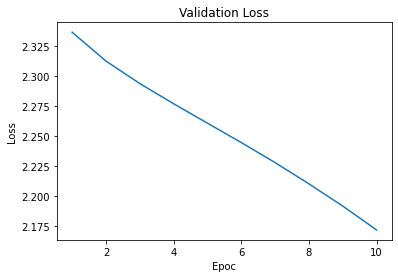

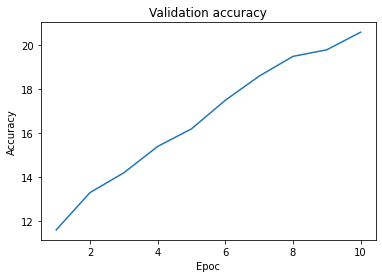

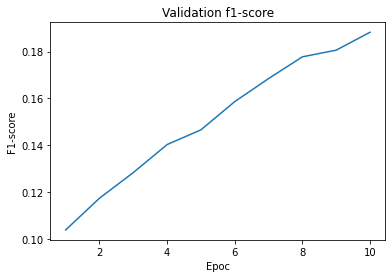

In [126]:
validation_losses = []
validation_accuracy = []
validation_f1 = []
validation_index = [i for i in range(1,11)]
for i in range(10):
    for j in range(0, 3200, 32):
        batch_x = cifar_subsample_x[j:j+32].reshape(32, 3, 32, 32).astype(np.float64)
        batch_x /= 255.0
        batch_y = cifar_subsample_y[j:j+32]
        model_out = batch_x
        # train
        for layer in model:
            model_out = layer.forward(model_out)

        true_labels = label_binarizer.transform(batch_y)
        l = loss_function(true_labels, model_out)

        model_back = true_labels
        for layer in reversed(model):
            model_back = layer.backward(model_back)

    #validation
    validation_out = validation_batch
    for layer in model:
        validation_out = layer.forward(validation_out)
    validation_loss = loss_function(validation_labels, validation_out)
    validation_losses.append(validation_loss)
    validation_predictions = predict_labels(validation_out)
    accuracy = accuracy_score(validation_labels, validation_predictions)
    validation_accuracy.append(accuracy*100)
    f1 = f1_score(y_true=validation_labels, y_pred=validation_predictions, average='macro')
    validation_f1.append(f1)

plt.plot(validation_index, validation_losses)
plt.title('Validation Loss')
plt.xlabel('Epoc')
plt.ylabel('Loss')
plt.show()
plt.plot(validation_index, validation_accuracy)
plt.title('Validation accuracy')
plt.xlabel('Epoc')
plt.ylabel('Accuracy')
plt.show()
plt.plot(validation_index, validation_f1)
plt.title('Validation f1-score')
plt.xlabel('Epoc')
plt.ylabel('F1-score')
plt.show()